<a href="https://colab.research.google.com/github/vknalluri/TS/blob/main/ARIMA_GOOGLE_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the Data...

In [1]:
#!pip install pmdarima
#!pip install statsmodels 

### somehow statsmodels is not working properly on colab. we need to install pmdarima and statsmodels first then Restart the runtime and then Run all.

import pandas as pd
import numpy as np
import seaborn as sns
import math

my_data = pd.read_csv('GOOGL.csv')
my_data.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,98.798798,101.921921,97.827827,101.456459,101.456459,31656712
1,2005-01-04,100.800804,101.566566,96.836838,97.347343,97.347343,27484288
2,2005-01-05,96.821823,98.548546,96.211212,96.851852,96.851852,16456727
3,2005-01-06,97.637634,98.048050,93.953957,94.369370,94.369370,20753426
4,2005-01-07,95.415413,97.222221,94.484482,97.022018,97.022018,19306474


Lets get the Descriptive Statistics.

In [2]:
my_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03
mean,505.671810,510.140559,500.828010,505.580766,505.580766,6.849096e+06
std,340.200096,342.818650,337.541716,340.316806,340.316806,7.664612e+06
min,87.737740,89.289291,86.371368,87.582581,87.582581,5.206000e+05
25%,242.516266,245.469223,240.380386,242.652649,242.652649,1.882950e+06
50%,333.788788,337.112106,329.894898,333.998992,333.998992,4.282713e+06
75%,748.687500,754.175003,740.242493,748.842484,748.842484,8.676315e+06
max,1364.000000,1367.050049,1353.000000,1362.469971,1362.469971,8.215117e+07


Lets check the variables and their datatypes.

In [3]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3774 non-null   object 
 1   Open       3774 non-null   float64
 2   High       3774 non-null   float64
 3   Low        3774 non-null   float64
 4   Close      3774 non-null   float64
 5   Adj Close  3774 non-null   float64
 6   Volume     3774 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 206.5+ KB


my_data.info() shows that data type of Date is object. Hence we need to convert it into datetime datatype and index it.

In [4]:
import datetime

my_data['Date'] = pd.to_datetime(my_data['Date'])
my_data.set_index('Date', inplace=True)
my_data.info()
my_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3774 entries, 2005-01-03 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3774 non-null   float64
 1   High       3774 non-null   float64
 2   Low        3774 non-null   float64
 3   Close      3774 non-null   float64
 4   Adj Close  3774 non-null   float64
 5   Volume     3774 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 206.4 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,98.798798,101.921921,97.827827,101.456459,101.456459,31656712
2005-01-04,100.800804,101.566566,96.836838,97.347343,97.347343,27484288
2005-01-05,96.821823,98.548546,96.211212,96.851852,96.851852,16456727
2005-01-06,97.637634,98.048050,93.953957,94.369370,94.369370,20753426
2005-01-07,95.415413,97.222221,94.484482,97.022018,97.022018,19306474


Our variable of interest is Adj Close which is regressed onto itself in ARIMA, hence lets vizualise the variable.

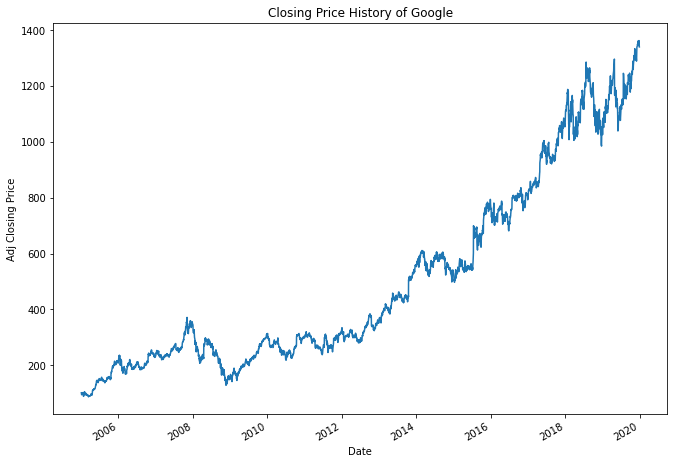

In [5]:
import matplotlib.pyplot as plt
#%matplotlib inline

plt.figure(figsize=(11, 8)) # resizing the plot
my_data['Adj Close'].plot()
plt.title('Closing Price History of Google') # adding the title
plt.xlabel('Date') # x label
plt.ylabel('Adj Closing Price') # y label
plt.show()

Checking for null values in the dataset

In [6]:
my_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There are no null values in the dataset



Let us check for the stationarity of the data (we will consider the variable Adj close only). We will use augmented Dekey Fuller to test if the variable series is stationary or not. Null hypothesis of the dekey fuller test is there are unit roots: series is not stationary.

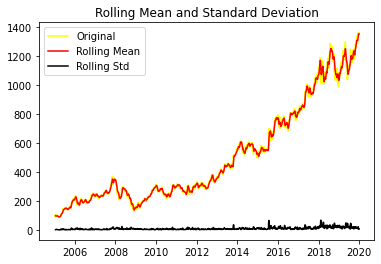

Results of dickey fuller test
Test Statistics                   0.912261
p-value                           0.993248
No. of lags used                 18.000000
Number of observations used    3755.000000
critical value (1%)              -3.432093
critical value (5%)              -2.862310
critical value (10%)             -2.567180
dtype: float64


In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
#from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error


def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us the values without defining what the values are.
    #hence we use a for loop to print the values with definitions
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(my_data['Adj Close'])

From the results , we can see that mean and standard deviation are not constant - rules for the stationarity.

Further, from augmented Dekey Fuller test, since p-value is greaterthan 0.05 and Test Statistics is greaterthan critical value(5%) , we fail to reject the null hypothesis., meaning that series is not stationary.



We will make the series stationary by taking the log difference of the series.

In [8]:
def calc_return(dataframe, lag = 1):
    """
    Adds a column of the previous close to the dataframe. Lag is a user-input parameter.
    """
    prevClose = [x for x in my_data['Adj Close'][:-lag]]
    prevClose = [np.nan for i in range(lag)] + prevClose
    my_data[f'{lag}-day prevClose'] = prevClose
    my_data['return'] = np.log(my_data[f'{lag}-day prevClose']).diff()
   

    return my_data

calc_return(my_data, lag=1)


,Open,High,Low,Close,Adj Close,Volume,1-day prevClose,return
Date,,,,,,,,
2005-01-03,98.798798,101.921921,97.827827,101.456459,101.456459,31656712,NaN,NaN
2005-01-04,100.800804,101.566566,96.836838,97.347343,97.347343,27484288,101.456459,NaN
2005-01-05,96.821823,98.548546,96.211212,96.851852,96.851852,16456727,97.347343,-0.041344
2005-01-06,97.637634,98.048050,93.953957,94.369370,94.369370,20753426,96.851852,-0.005103
2005-01-07,95.415413,97.222221,94.484482,97.022018,97.022018,19306474,94.369370,-0.025966
...,...,...,...,...,...,...,...,...
2019-12-23,1358.729980,1361.849976,1348.000000,1350.630005,1350.630005,996800,1351.219971,-0.003856
2019-12-24,1350.209961,1352.010010,1344.170044,1344.430054,1344.430054,673400,1350.630005,-0.000437
2019-12-26,1346.550049,1363.199951,1345.510010,1362.469971,1362.469971,1183100,1344.430054,-0.004601


We will test for the stationarity after diffrencing in the above step.

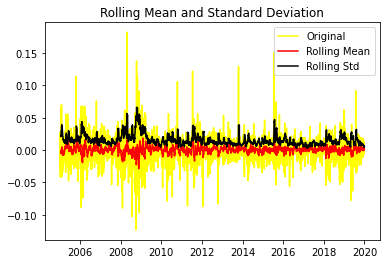

Results of dickey fuller test
Test Statistics                 -61.571473
p-value                           0.000000
No. of lags used                  0.000000
Number of observations used    3771.000000
critical value (1%)              -3.432085
critical value (5%)              -2.862307
critical value (10%)             -2.567178
dtype: float64


,Open,High,Low,Close,Adj Close,Volume,1-day prevClose,return
Date,,,,,,,,
2005-01-05,96.821823,98.548546,96.211212,96.851852,96.851852,16456727,97.347343,-0.041344
2005-01-06,97.637634,98.048050,93.953957,94.369370,94.369370,20753426,96.851852,-0.005103
2005-01-07,95.415413,97.222221,94.484482,97.022018,97.022018,19306474,94.369370,-0.025966
2005-01-10,97.347343,99.149147,96.011009,97.627625,97.627625,15064121,97.022018,0.027721
2005-01-11,97.907906,98.953957,96.686684,96.866867,96.866867,13903483,97.627625,0.006223
...,...,...,...,...,...,...,...,...
2019-12-23,1358.729980,1361.849976,1348.000000,1350.630005,1350.630005,996800,1351.219971,-0.003856
2019-12-24,1350.209961,1352.010010,1344.170044,1344.430054,1344.430054,673400,1350.630005,-0.000437
2019-12-26,1346.550049,1363.199951,1345.510010,1362.469971,1362.469971,1183100,1344.430054,-0.004601


In [9]:
 my_data1 = my_data[2:]
 test_stationarity(my_data1['return'])
 my_data1

Return series is stationary now. We reject the null as P and test statistic are lessthan 0.05.

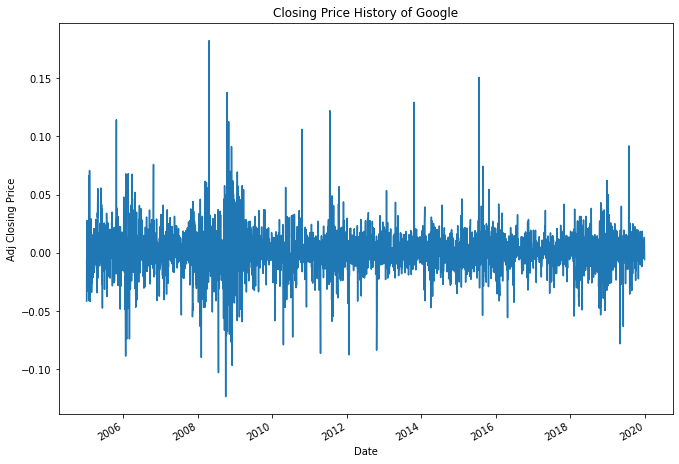

In [10]:
plt.figure(figsize=(11, 8)) # resizing the plot
my_data1['return'].plot()
plt.title('Closing Price History of Google') # adding the title
plt.xlabel('Date') # x label
plt.ylabel('Adj Closing Price') # y label
plt.show()

Further, mean and SD of the series are constant. So series is stationary.

Lets plot the auto correlation and partial auto correlation functions to find the optimal AR and MA terms.

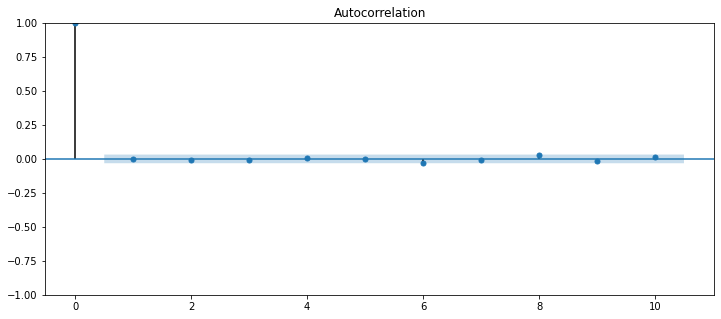

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


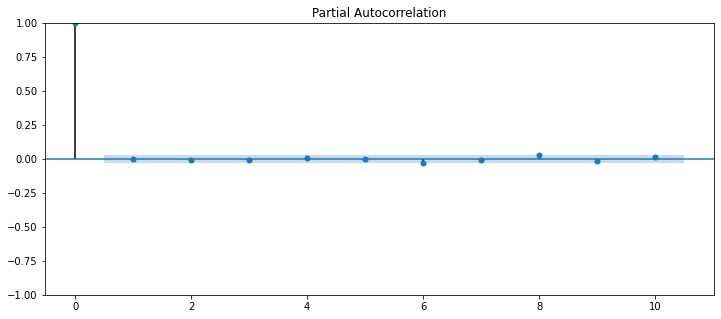

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_acf(my_data1['return'], lags=10, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(my_data1['return'], lags=10, ax=ax)
plt.show()

Optimal AR and MA terms are 6 and 6 respectively.

Some studies say that we should split the datset into train and test. But observation is that its not required as ARIMA is based on past observations of the same variable.

Lets build the ARIMA model and fit it to the variable.

In [12]:

from statsmodels.tsa.arima.model import ARIMA


#Modeling
# Build Model
model = ARIMA(my_data1['Adj Close'], order=(6,1,6)).fit()
 
print(model.summary())



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 3772
Model:                 ARIMA(6, 1, 6)   Log Likelihood              -13676.745
Date:                Wed, 04 May 2022   AIC                          27379.490
Time:                        00:50:47   BIC                          27460.546
Sample:                             0   HQIC                         27408.308
                               - 3772                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9015      0.042    -21.482      0.000      -0.984      -0.819
ar.L2          0.5237      0.050     10.545      0.000       0.426       0.621
ar.L3          1.4482      0.055     26.125      0.0

P value for MA6 term is optimal and also the coefficient is high. So our model selection is good (6,1,6).

Lets predict the values and compare them against the actual values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


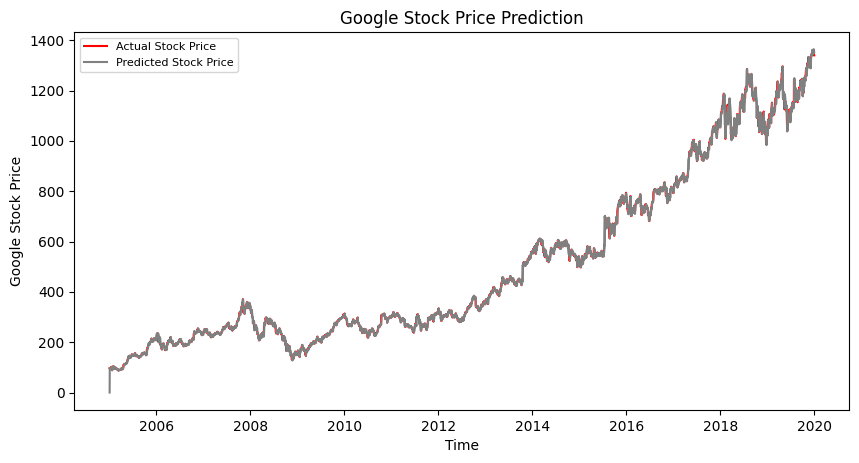

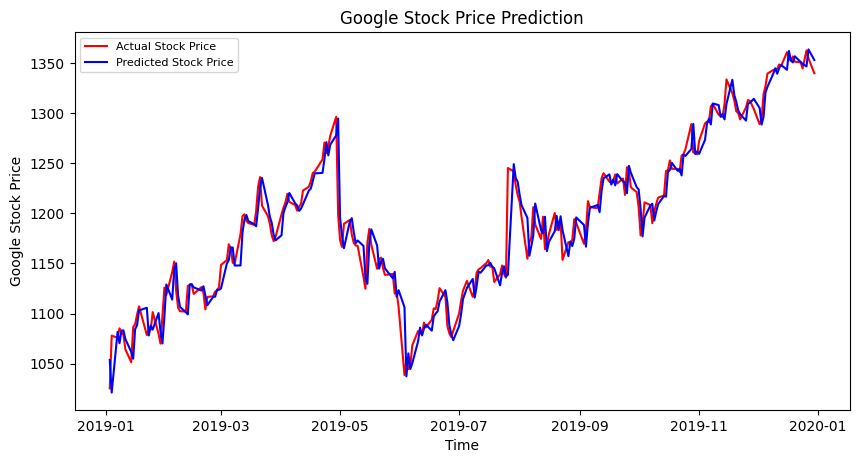

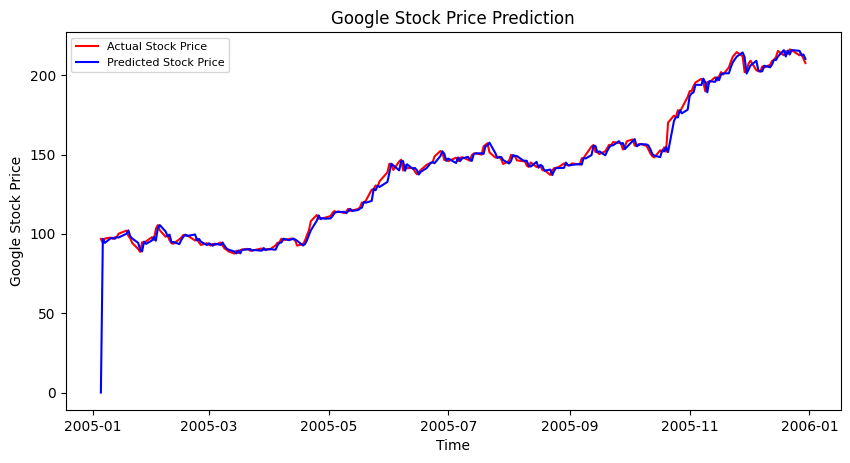

In [18]:


my_data1['yhat'] = (model.fittedvalues)


my_data1_first = my_data1.head(250)
my_data1_last = my_data1[-250:]


# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(train_data, label='training data')
plt.plot(my_data1['Adj Close'], color = 'red', label='Actual Stock Price')
plt.plot(my_data1['yhat'], color = 'grey',label='Predicted Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()




# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(train_data, label='training data')
plt.plot(my_data1_last['Adj Close'], color = 'red', label='Actual Stock Price')
plt.plot(my_data1_last['yhat'], color = 'blue',label='Predicted Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()




# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(train_data, label='training data')
plt.plot(my_data1_first['Adj Close'], color = 'red', label='Actual Stock Price')
plt.plot(my_data1_first['yhat'], color = 'blue',label='Predicted Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()







Results are impressive....

Lets Calculate the metrics

In [14]:
# report performance
mse = mean_squared_error(my_data1['Adj Close'], my_data1['yhat'])
print('MSE: '+str(mse))
mae = mean_absolute_error(my_data1['Adj Close'], my_data1['yhat'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(my_data1['Adj Close'], my_data1['yhat']))
print('RMSE: '+str(rmse))


MSE: 85.2031064132207
MAE: 5.567702167422548
RMSE: 9.230552876898582


MAE indicates that predictions differ from actuals by 5.56 and its risky.

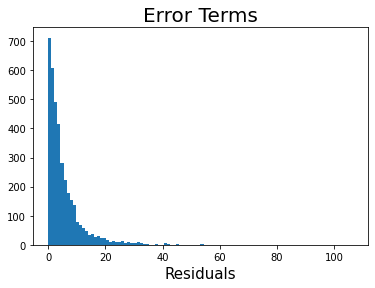

In [15]:
residuals1 = abs(my_data1['yhat'] - my_data1['Adj Close'])
plt.hist(residuals1.values, bins=100)
plt.title('Error Terms', fontsize=20)           
plt.xlabel('Residuals', fontsize = 15)     
plt.show();
